In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Move to working folder
%cd /content/drive/MyDrive/Projects/AIA

/content/drive/MyDrive/Projects/AIA


In [66]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utils.lbp import LBP
from utils.dataset import load_yolo_labels
from utils.iou import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


In [3]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = '/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'txt'

## Histogram Matching

In [3]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)

In [ ]:
## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if i > 10:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [17]:
def preprocess(image, mean_histogram=None, dilate_num=4):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


In [18]:
def lbp_extraction(image_path, intensity_crop=0.1, outputbitdepth=8, mean_histogram=None, lbp=None):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    ### Parse label
    image_name = os.path.basename(image_path)
    label_path = os.path.join(root_path, label_folder, image_name.replace('.png', '.txt'))
    labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Histogram equalization
    img = exposure.rescale_intensity(img, in_range=(np.percentile(img, intensity_crop), np.percentile(img, (100-intensity_crop))))
    img = exposure.equalize_adapthist(img)
    
    ## Normalize image
    img = cv2.normalize(img, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    ## Segment bones
    img = preprocess(img, mean_histogram=mean_histogram)
    
    ## Extract LBP features
    if lbp is not None:
        lbp_image = lbp.get_lbp_image(img)
        return lbp_image, labels
    else:
        return img, labels

## Extract Features

In [5]:
windowSize =256
stepSize = 128 
# Parameters for LBP
num_points = 16  # Typically 8, 16, or 24
radius = 7       # Typical values are 1, 2, or 3
background_removal_threshold = 30 # Threshold for removing background in percentage

In [6]:
convert_grayscale = False
outputbitdepth = 8 # Set output bit depth
sharpen = False # Sharpen image
convert_grayscale = False # Convert to grayscale
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

In [ ]:
for root, dirs, file_names in os.walk(root_path):
    if '.DS_Store' in file_names:
        os.remove(os.path.join(root, '.DS_Store'))
    if len(file_names):
        for file_name in file_names:
            ### Get image and label path
            image_path = os.path.join(root, file_name)
            class_name = image_path.split(os.path.sep)[-2]
            class_name = image_path.split(os.path.sep)[-2]
            
            if '.png' in image_path:
                print(f"Processing {file_name}, class: {class_name}") 
                ## Read image
                org_img = cv2.imread(image_path, -cv2.IMREAD_ANYDEPTH)
                ### Parse label
                label_path = os.path.join(root_path, label_folder, file_name.replace('.png', '.txt'))
                labels = load_yolo_labels(label_path, org_img.shape, [3]) # 3 is the class index for fracture
                    
                ## Histogram equalization
                img = exposure.rescale_intensity(org_img, in_range=(np.percentile(org_img, intensity_crop), np.percentile(org_img, (100-intensity_crop))))
                img = exposure.equalize_adapthist(img)
                ## Sharpen image
                if sharpen == True:
                    img = unsharp_mask(img, radius=1, amount=1)
                
                ## Normalize image
                if outputbitdepth == 8:
                    img = cv2.normalize(img, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
                elif outputbitdepth == 16:
                    img = cv2.normalize(img, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint16)
                
                img = process_image(img, mean_histogram=mean_histogram)
                
                # Calculate number of subplots needed
                if stepSize < 1 and windowSize < 1:
                    stepSize = int(img.shape[1] * stepSize)
                    windowSize = int(img.shape[1] * windowSize)
                ny = (img.shape[0] - windowSize) // stepSize + 1
                nx = (img.shape[1] - windowSize) // stepSize + 1
                fig, axs = plt.subplots(nrows=ny, ncols=nx, figsize=(nx*2, ny*2))
                
                for i, (x, y, window_img) in enumerate(sliding_window(img, stepSize=stepSize, windowSize=windowSize)):
                    # Get row and column index for subplot
                    row = y // stepSize
                    col = x // stepSize
                
                    # Plot window
                    ax = axs[row, col] if ny > 1 and nx > 1 else axs[max(row, col)]
                    
                    ## Local Binary Pattern
                    lbp = LBP(num_points, radius)
                    lbp_image = lbp.get_lbp_image(window_img)
                    lbp_hist = lbp.histogram(lbp_image)
                    
                    hist, bins = np.histogram(window_img.flatten(), bins=256, range=[0, 256])
                    black_percentage = (hist[0]/hist.sum())*100
                    # if black_percentage > background_removal_threshold:
                    #     print(f"Skip window ({x}, {y}) due to high black pixels percentage: {black_percentage:.2f}%")
                    
                    ## Check iou with label
                    iou_score = 0
                    if len(labels):
                        for label in labels:
                            c, *xyxy = label
                            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
                    
                    ax.imshow(lbp_image, cmap='gray')
                    ax.axis('off')
                    ax.set_title(f"({x}, {y}) - {iou_score:.2f}, {(hist/hist.sum()*100)[0]:.2f}%")
                
                plt.tight_layout()
                plt.show()
            break


In [ ]:
### Extract LBP features and export to npy file
mode = 'test'
class_name = 'normal'
export_path_fracture = os.path.join(root_path, f'{mode}_{class_name}_lbp.npy')
export_path_non_fracture = os.path.join(root_path, f'{mode}_non_{class_name}_lbp.npy')
export_path_normal = os.path.join(root_path, f'{mode}_normal_lbp.npy')

fracture_features = []
non_fracture_features = []

### Local Binary Pattern
lbp = LBP(num_points, radius)
### Loop through all images
for image_path in glob.glob(os.path.join(root_path, mode, class_name, '*.png')):
    print(f"Processing {image_path}")
    
    ### Extract LBP features
    lbp_image, labels = lbp_extraction(image_path, mean_histogram=mean_histogram, lbp=lbp)
    
    for i, (x, y, lbp_window) in enumerate(sliding_window(lbp_image, stepSize=stepSize, windowSize=windowSize)):
        ## Image histogram 
        hist, bins = np.histogram(lbp_window.flatten(), bins=256, range=[0, 256])
        ## Calculate black pixels percentage
        # black_percentage = (hist[0]/hist.sum())*100
        # print(black_percentage)
        # if black_percentage > background_removal_threshold:
        #     # print(f"Skip window ({x}, {y}) due to high black pixels percentage: {black_percentage:.2f}%")
        #     continue
        lbp_features = lbp_window.ravel()
        
        is_fracture = False
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.7:
                fracture_features.append(lbp_features)
                is_fracture = True
                break
        # If no label has matched after checking all, it's a non-fracture case
        if not is_fracture:
            non_fracture_features.append(lbp_features)
            

In [28]:
np.save(export_path_normal, np.array(non_fracture_features))

In [20]:
np.save(export_path_fracture, fracture_features)
np.save(export_path_non_fracture, non_fracture_features)

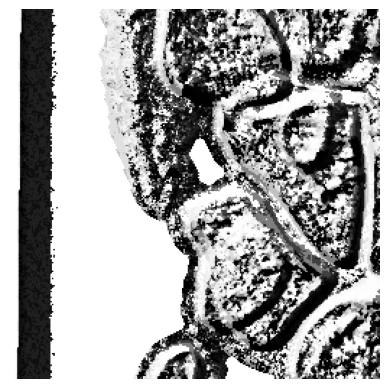

In [21]:
plt.imshow(non_fracture_features[5].reshape(256, 256), cmap='gray')
plt.axis('off')
plt.show()

## Machine Learning Model

### Load data

In [3]:
dataset_path = '/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/'

In [87]:
train_normal_features = np.load(os.path.join(dataset_path, 'train_normal_lbp.npy'))[:100]
train_fracture_features = np.load(os.path.join(dataset_path, 'train_fracture_lbp.npy'))[:100]
train_features = np.concatenate([train_normal_features, train_fracture_features])
train_labels = np.array([0] * len(train_normal_features) + [1] * len(train_fracture_features))

test_normal_features = np.load(os.path.join(dataset_path, 'test_normal_lbp.npy'))
test_fracture_features = np.load(os.path.join(dataset_path, 'test_fracture_lbp.npy'))
test_features = np.concatenate([test_normal_features, test_fracture_features])
test_labels = np.array([0] * len(test_normal_features) + [1] * len(test_fracture_features))

In [92]:
## Histogram of LBP features
train_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in train_features]
test_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in test_features]

In [93]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

### Training

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
# model = SVC(kernel='linear')
# model = RandomForestClassifier(n_estimators=200, random_state=42)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [95]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67        21
           1       0.62      0.42      0.50        19

    accuracy                           0.60        40
   macro avg       0.60      0.59      0.58        40
weighted avg       0.60      0.60      0.59        40



In [91]:
# Evaluate the model on the valid set
y_pred_test = model.predict(test_features)
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.63      0.73      3012
           1       0.13      0.40      0.20       426

    accuracy                           0.60      3438
   macro avg       0.51      0.51      0.47      3438
weighted avg       0.79      0.60      0.67      3438



In [79]:
# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_test)
print(cm)

[[1930 1082]
 [ 176  250]]
